In [1]:
import sklearn
import numpy as np
import os
# Import for week 3
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Prepare for plotting figure
# 시각화하기 위한 기본적인 패키지 임포트
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 정밀도와 재현율을 Threshold(임계값)에 따른 결과를 시각화하는 함수
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    plt.show()

# 정밀도 재현율을 시각화하는 함수
def plot_precision_recall_curve(recalls, precisions):
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
# AUC-ROC 커브를 시각화하는 함수
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)

# 첫번째 연습문제 

## Question 1: 
    7과8 숫자를 판별하는 이진 분류기를 생성하시오(‘7 & 8‘ 과 나머지 숫자 분류)

**< 단 조건 >**

1) 모델은 SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) 사용하시오.

2) 훈련셋과 테스트셋에서의 모델 정확도를 교차검증으로 보이시오. (단 학습 데이터(Train Dataset)에서는 정확도가 [0.87005 0.88305 0.8951 ] 이며, 테스트 데이터(Test Dataset)에서는 [0.8602 0.8674 0.8901]이와 크거나 같아야한다.)

3) 정밀도 재현율을 시각화하시오.
    
    1) 정밀도와 재현율을 Theshold(임계값)에 따른 변화를 시각화하시오.
    
    2) 정밀도와 재현율을 시각화해 트레이드 오프(trade off) 관계를 이해하시오.
    
4) ROC 커브를 시각화 및 점수를 구하시오.

    1) ROC 커브를 시각화하시오.
    
    2) ROC-AUC 점수를 구하시오.(단 점수가 0.8919 보다 크거나 같아야 한다.)

## 가이드 라인

### 1) 데이터 로드
### 1.1) MNIST DATA 로드

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### 1.2) Feature(x) 와 target(label or y) 를 구분

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


### 1.3) 로드된 데이터가 잘 가져왔는지 시각화하시오.(index 번호는 0번사용)

<시각화 힌트> 
* X[0] 사용
* plt.imshow(데이터) 사용하시오.

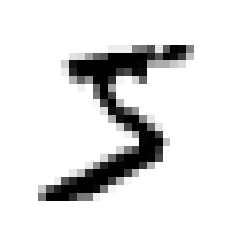

Label of this digit is:  5


In [4]:
# instead of using X[0]
some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()
print('Label of this digit is: ', y[0])

### 1.4)  target(y)의 데이터 타입을 확인 후 np.uint8로 변환하시오.

In [5]:
y = y.astype(np.uint8)

### 1.5) target(y) 데이터를 7 또는 8이 이면 1 아니면 0으로 변환하시오.

In [6]:
y = np.where(((y == 7) | (y == 8)), 1, 0)
print("y 값: ", y[:10])

y 값:  [0 0 0 0 0 0 0 0 0 0]


### 1.6) 데이터를 인덱스 60000 기준으로 Train과  Test 데이터로 나누시오.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


### 2) 모델
### 2.1) 모델 빌드

In [8]:
y_train_78 = (y_train == 1)
y_test_78 = (y_test == 1)
# Build Model
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

### 2.2) 모델 학습

In [9]:
sgd_clf.fit(X_train, y_train_78)

SGDClassifier(random_state=42)

### 2.3) 교차검증으로 일반화된 성능 평가

In [10]:
from sklearn.model_selection import cross_val_score
train_score = cross_val_score(sgd_clf, X_train, y_train_78, cv=3, scoring="accuracy")
test_score = cross_val_score(sgd_clf, X_test, y_test_78, cv=3, scoring="accuracy")

print("train score: ", train_score, "test_score: ", test_score)

train score:  [0.87005 0.88305 0.8951 ] test_score:  [0.86022795 0.86738674 0.89018902]


### 3) 성능 평가
### 3.1) 정밀도 재현율을 시각화하시오.
### 3.1.1) 정밀도와 재현율을 Threshold(임계값)에 따른 변화를 시각화하시오.

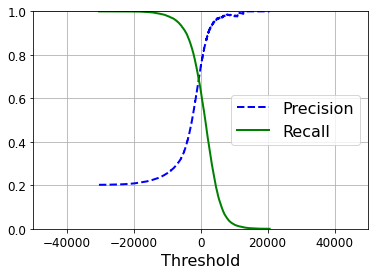

In [11]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_78, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_78, y_scores)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### 3.1.2) 정밀도와 재현율을 시각화해 트레이드 오프(trade off) 관계를 이해하시오.

* 트레이드 오프(trade off) : 서로 반비례 관계로 하나의 요소가 오르면 다른 요소는 감소하는 관계를 말합니다.

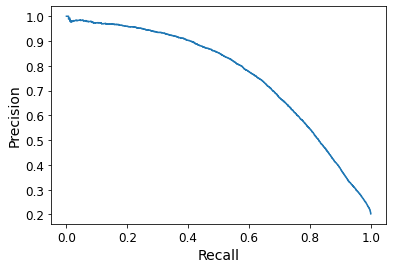

In [12]:
plot_precision_recall_curve(recalls, precisions)

### 3.2) ROC 커브를 시각화 및 점수를 구하시오.
### 3.2.1) ROC 커브를 시각화하시오.

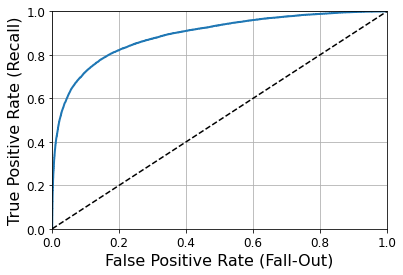

In [13]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_78, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

### 3.2.2) ROC-AUC 점수를 구하시오.(단 점수가 0.8919 보다 크거나 같아야 한다.)

In [14]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_78, y_scores)

0.891931232637452

## Question 2: 
       5보다 작은 숫자와 나머지 숫자를 분류하는 이진분류기를 만드시오
       .... [Build a binary classifier to detect numbers < 5 (e.g., 0,1,2,3,4)]


**< 단 조건 >**

1) 모델은 SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) 사용하시오.

2) 훈련셋과 테스트셋에서의 모델 정확도를 교차검증으로 보이시오. (단 학습 데이터(Train Dataset)에서는 정확도가  [0.82475 0.76475 0.8451 ]  이며, 테스트 데이터(Test Dataset)에서는 [0.77564487 0.8229823  0.83768377]이와 크거나 같아야한다.)

3) 정밀도 재현율을 시각화하시오.
    
    1) 정밀도와 재현율을 Theshold(임계값)에 따른 변화를 시각화하시오.
    
    2) 정밀도와 재현율을 시각화해 트레이드 오프(trade off) 관계를 이해하시오.
    
4) ROC 커브를 시각화 및 점수를 구하시오.

    1) ROC 커브를 시각화하시오.
    
    2) ROC-AUC 점수를 구하시오.(단 점수가  0.8872 보다 크거나 같아야 합니다.)

### 1) 데이터 로드
### 1.1) MNIST DATA 로드

In [15]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### 1.2) Feature(x) 와 target(label or y) 를 구분

In [16]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


### 1.3)  target(y)의 데이터 타입을 확인 후 np.uint8로 변환하시오.

In [17]:
y = y.astype(np.uint8)

### 1.4) target(y) 데이터가 5보다 작으면 1 아니면 0으로 변환하시오.

In [18]:
y = np.where(y < 5, 1, 0)

### 1.5) 데이터를 인덱스 60000 기준으로 Train과  Test 데이터로 나누시오

In [19]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 2) 모델
### 2.1) 모델 빌드

In [20]:
y_train_new = (y_train == 1)
y_test_new = (y_test == 1)
# Build Model
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

### 2.2) 모델 학습

In [21]:
sgd_clf.fit(X_train, y_train_new)

SGDClassifier(random_state=42)

### 2.3) 교차검증으로 일반화된 성능 평가

In [22]:
train_score = cross_val_score(sgd_clf, X_train, y_train_new, cv=3, scoring="accuracy")
test_score = cross_val_score(sgd_clf, X_test, y_test_new, cv=3, scoring="accuracy")

print("train score: ", train_score, "test_score: ", test_score)

train score:  [0.82475 0.76475 0.8451 ] test_score:  [0.77564487 0.8229823  0.83768377]


### 3) 성능 평가
### 3.1) 정밀도 재현율을 시각화하시오.
### 3.1.1) 정밀도와 재현율을 Theshold(임계값)에 따른 변화를 시각화하시오.

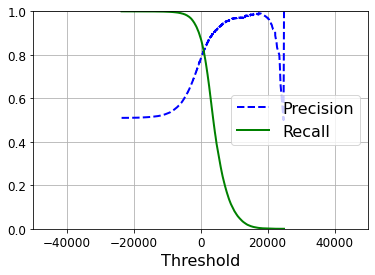

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_new, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_new, y_scores)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### 3.1.2) 정밀도와 재현율을 시각화해 트레이드 오프(trade off) 관계를 이해하시오.

* 트레이드 오프(trade off) : 서로 반비례 관계로 하나의 요소가 오르면 다른 요소는 감소하는 관계를 말합니다.

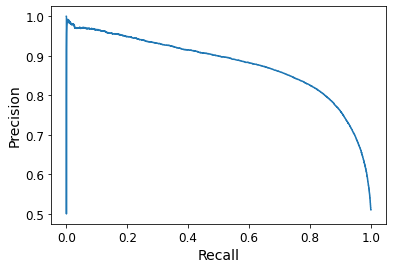

In [24]:
plot_precision_recall_curve(recalls, precisions)

### 3.2) ROC 커브를 시각화 및 점수를 구하시오.
### 3.2.1) ROC 커브를 시각화하시오.

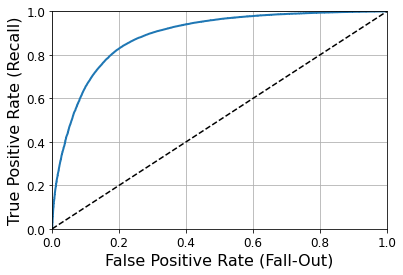

In [25]:
fpr, tpr, thresholds = roc_curve(y_train_new, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

### 3.2.2) ROC-AUC 점수를 구하시오.(단 점수가 0.8872 보다 크거나 같아야 합니다.)

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_new, y_scores)

0.8872733641058934